**Name:** \_\_\_\_\_

**EID:** \_\_\_\_\_

# CS4487 - Tutorial 4
## Face Detection in Images

In this tutorial you will train a classifier to detect whether there is a face in a small image patch.  This type of face detector is used in your phone and camera whenever you take a picture!

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import IPython.utils.warn as warn
random.seed(100)
from scipy import ndimage
from scipy import signal
import skimage.color
import skimage.exposure
import skimage.io
import skimage.util

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
//anaconda/lib/python2.7/

## 1. Loading Data and Pre-processing
Next we need to load the images.  Download `faces.zip`, and unzip it in the same directory as this ipynb file.  Then run the following cell to load the images.

In [2]:
filelist = glob.glob('faces/*/*/*.png')

if len(filelist) == 0:
    warn.error("Could not find images in faces directory!  " + 
               "Make sure you put it here: " + os.getcwd() )
else:
    imgdata = {'train':[], 'test':[]}
    classes = {'train':[], 'test':[]}

    for f in filelist:
        img = skimage.io.imread(f)
        # convert to grayscale
        img = skimage.color.rgb2gray(img)

        # filename is : faces/train/face/fname.png
        (fdir1, fname)  = os.path.split(f)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (face, nonface)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        
        # class 1 = face; class 0 = non-face
        myclass = int(fclass == "face")  

        imgdata[fset].append(img)
        classes[fset].append(myclass)
    imgsize = img.shape

testclass2start = sum(classes['test'])

# dataset is too big, so take a subset
subsample = 8  # reduce by a factor of 8
imgdata['train'] = imgdata['train'][::subsample]
classes['train'] = classes['train'][::subsample]
imgdata['test']  = imgdata['test'][:2*testclass2start]
classes['test']  = classes['test'][:2*testclass2start]
print len(imgdata['train'])
print len(imgdata['test'])

trainclass2start = sum(classes['train'])

873
944


Each image is a 19x19 array of pixel values.  Run the below code to show an example:

(19, 19)


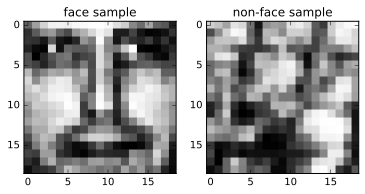

In [3]:
print img.shape
plt.subplot(1,2,1)
plt.imshow(imgdata['train'][0], cmap='gray', interpolation='nearest')
plt.title("face sample")
plt.subplot(1,2,2)
plt.imshow(imgdata['train'][trainclass2start], cmap='gray', interpolation='nearest')
plt.title("non-face sample")
plt.show()

Run the below code to show more images!

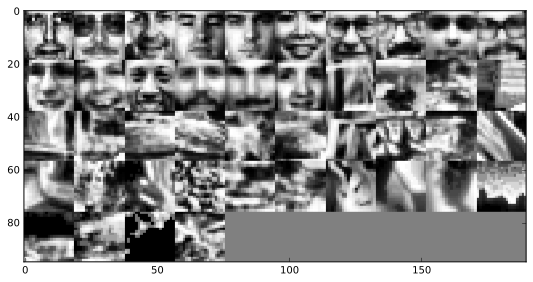

In [4]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(X[i])
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

# show a few images
plt.figure(figsize=(9,9))
plt.imshow(image_montage(imgdata['train'][::20]), cmap='gray', interpolation='nearest')
plt.show()

Each image is a 2d array, but the classifier algorithms work on 1d vectors. Run the following code to convert all the images into 1d vectors by flattening.  The result should be a matrix where each row is a flattened image.

In [5]:
trainX = empty((len(imgdata['train']), prod(imgsize)))
for i,img in enumerate(imgdata['train']):
    trainX[i,:] = ravel(img)
trainY = asarray(classes['train'])  # convert list to numpy array
print trainX.shape
print trainY.shape

testX = empty((len(imgdata['test']), prod(imgsize)))
for i,img in enumerate(imgdata['test']):
    testX[i,:] = ravel(img)
testY = asarray(classes['test'])  # convert list to numpy array
print testX.shape
print testY.shape

(873, 361)
(873,)
(944, 361)
(944,)


## 2. Detection using  pixel values

Train an AdaBoost classifier to classify an image patch as face or non-face.  Also train a kernel SVM classifier using either RBF or polynomial kernel, and a Random Forest Classifier.  Evaluate all your classifiers on the test set.

Don't forget to normalize your features!

In [6]:
### INSERT YOUR CODE HERE
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))    # make scaling object
trainXn = scaler.fit_transform(trainX)   # use training data to fit scaling parameters
testXn  = scaler.transform(testX)        # apply scaling to test data

clfs = {}

In [7]:
# setup all the parameters and models
exps = {
    'svm-lin': {
        'paramgrid': {'C': logspace(-2,3,10)},
        'clf': svm.SVC(kernel='linear') },
    'svm-rbf': {
        'paramgrid': {'C': logspace(-2,3,10), 'gamma': logspace(-4,3,10) },
        'clf': svm.SVC(kernel='rbf') },
    'svm-poly': {
        'paramgrid': {'C': logspace(-2,3,10), 'degree': [2, 3, 4] },
        'clf': svm.SVC(kernel='poly') },   
    'ada': {
        'paramgrid': {'n_estimators': [2, 5, 10, 15, 20, 25, 30, 50, 100]},
        'clf': ensemble.AdaBoostClassifier(random_state=4487) },
    'rf': {
        'paramgrid': {'n_estimators': [2, 5, 10, 15, 20, 25, 30, 50, 100]},
        'clf': ensemble.RandomForestClassifier(random_state=4487) },
    }

In [8]:
# run the experiment
for (name,ex) in exps.iteritems():
    print "=== " + name + " ==="
    if clfs.has_key(name):
        print "exists skipping"
    else:
        myclf = grid_search.GridSearchCV(ex['clf'], ex['paramgrid'], cv=5, verbose=1)
        myclf.fit(trainXn, trainY)

        print "best params:"
        print myclf.best_params_

        clfs[name] = myclf

=== svm-lin ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.9s finished


best params:
{'C': 0.46415888336127797}
=== rf ===
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    8.5s finished


best params:
{'n_estimators': 100}
=== ada ===
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   22.7s finished


best params:
{'n_estimators': 100}
=== svm-rbf ===
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.8min finished


best params:
{'C': 1.6681005372000592, 'gamma': 0.0035938136638046258}
=== svm-poly ===
Fitting 5 folds for each of 30 candidates, totalling 150 fits
best params:
{'C': 21.544346900318846, 'degree': 2}


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   22.6s finished


In [9]:
predYtrain = {}
predYtest  = {}
for (name,clf) in clfs.iteritems():
    predYtrain[name] = clf.predict(trainXn)
    predYtest[name]  = clf.predict(testXn)
    
    # calculate accuracy
    trainacc = metrics.accuracy_score(trainY, predYtrain[name])
    testacc  = metrics.accuracy_score(testY, predYtest[name])

    print "%10s: train=%0.3f; test=%0.3f" % (name, trainacc, testacc)

   svm-lin: train=1.000; test=0.577
        rf: train=1.000; test=0.644
  svm-poly: train=1.000; test=0.686
   svm-rbf: train=0.995; test=0.648
       ada: train=1.000; test=0.644


In [10]:
# set variables for later
predY = predYtest['svm-poly']
adaclf = clfs['ada'].best_estimator_
svmclf = clfs['svm-poly'].best_estimator_
rfclf  = clfs['rf'].best_estimator_

_Which classifier was best?_
- INSERT YOUR ANSWER HERE
- SVM polynomial

### Error analysis
The accuracy only tells part of the classifier's performance. We can also look at the different types of errors that the classifier makes:
- _True Positive (TP)_: classifier correctly said face
- _True Negative (TN)_: classifier correctly said non-face
- _False Positive (FP)_: classifier said face, but not a face
- _False Negative (FN)_: classifier said non-face, but was a face

This is summarized in the following table:

<table>
<tr><th colspan=2 rowspan=2><th colspan=2 style="text-align: center">Actual</th></tr>
<tr>  <th>Face</th><th>Non-face</th></tr>
<tr><th rowspan=2>Prediction</th><th>Face</th><td>True Positive (TP)</td><td>False Positive (FP)</td></tr>
<tr>  <th>Non-face</th><td>False Negative (FN)</td><td>True Negative (TN)</td></tr>
</table>

We can then look at the _true positive rate_ and the _false positive rate_.
- _true positive rate (TPR)_: proportion of true faces that were correctly detected
- _false positive rate (FPR)_: proportion of non-faces that were mis-classified as faces.

Use the below code to calculate the TPR and FPR of your classifiers.

In [11]:
# predY is the prediction from the classifier

Pind = where(testY==1) # indicies for face
Nind = where(testY==0) # indicies for non-face
TP = count_nonzero(testY[Pind] == predY[Pind])
FP = count_nonzero(testY[Pind] != predY[Pind])
TN = count_nonzero(testY[Nind] == predY[Nind])
FN = count_nonzero(testY[Nind] != predY[Nind])

TPR = float(TP) / (TP+FN)
FPR = float(FP) / (FP+TN)

print "TP="+str(TP)
print "FP="+str(FP)
print "TN="+str(TN)
print "FN="+str(FN)
print "TPR="+str(TPR)
print "FPR="+str(FPR)

TP=179
FP=293
TN=469
FN=3
TPR=0.983516483516
FPR=0.384514435696


_How does the classifier make errors?_
- INSERT YOUR ANSWER HERE
- high TPR, means it gets all the faces, but high FPR also means it misdetects things as faces.

### Classifier analysis

For the AdaBoost classifier, we can interpret what it is doing by looking at which features it uses most in the weak learners.  Use the below code to visualize the pixel features used.

Note: if you used GridSearchCV to train the classifier, then you need to use the `best_estimator_` field to access the classifier.

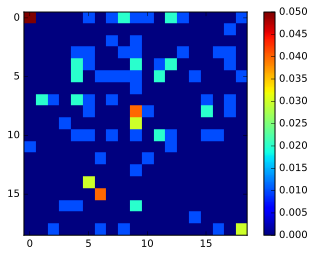

In [12]:
# adaclf is the trained adaboost classifier
fi = adaclf.feature_importances_.reshape(imgsize)
plt.imshow(fi, interpolation='nearest')
plt.colorbar()

Similarly for Random Forests, we can look at the important features.

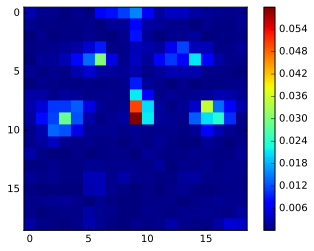

In [13]:
# rfclf is the trained random forest classifier
fi = rfclf.feature_importances_.reshape(imgsize)
plt.imshow(fi, interpolation='nearest')
plt.colorbar()

Comment on which features (pixels) that AdaBoost and Random Forests are using
- INSERT YOUR ANSWER HERE
- Adaboost: most of the features are around the face, but some are in the corners which is weird. They are all spread out randomly
- RF: the features are localized in some areas (eyes, nose, cheeks)

For kernel SVM, we can look at the support vectors to see what the classifier finds difficult.

num support vectors: 234


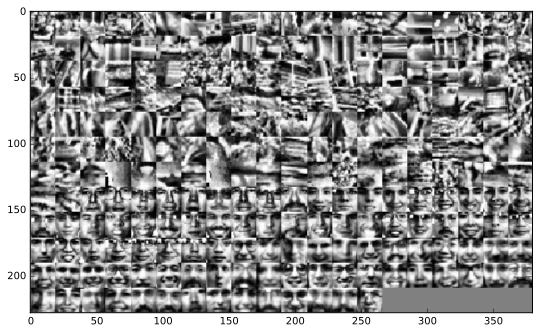

In [14]:
# svmclf is the trained SVM classifier

print "num support vectors:", len(svmclf.support_vectors_)
si  = svmclf.support_  # get indicies of support vectors

# get all the patches for each support vector
simg = [ imgdata['train'][i] for i in si ]

# make montage
outimg = image_montage(simg, maxw=20)

plt.figure(figsize=(9,9))
plt.imshow(outimg, cmap='gray', interpolation='nearest')

Comment on anything you notice about what the SVM finds difficult (i.e., on the decision boundary or within the margin)
- INSERT YOUR ANSWER HERE
- glasses on faces.  some non-faces look like faces.

## 3. Image Feature Extraction
The detection performance is not that good. The problem is that we are using the raw pixel values as features, so it is difficult for the classifier to interpret larger structures of the face that might be important.  To fix the problem, we will extract features from the image using a set of filters.

Run the below code to look at the filter output.  The filters are a sets of black and white boxes that respond to similar structures in the image.  After applying the filters to the image, the filter response map is aggregated over a 4x4 window.  Hence each filter produces a 5x5 feature response.  Since there are 4 filters, then the feature vector is 100 dimensions.

In [15]:
def extract_features(imgs, doplot=False):
    # the filter layout
    lay = [array([-1,1]), array([-1,1,-1]),  
               array([[1],[-1]]), array([[-1],[1],[-1]])]
    sc=8            # size of each filter patch
    poolmode = 'i'  # pooling mode (interpolate)
    cmode = 'same'  # convolution mode
    brick = ones((sc,sc))  # filter patch
    ks = []
    for l in lay:
        tmp = [brick*i for i in l]
        if (l.ndim==1):
            k = hstack(tmp)
        else:
            k = vstack(tmp)
        ks.append(k)

    # get the filter response size
    if (poolmode=='max') or (poolmode=='absmax'):
        tmpimg = maxpool(maxpool(imgs[0]))
    else:
        tmpimg = ndimage.interpolation.zoom(imgs[0], 0.25)        
    fs = prod(tmpimg.shape)
    
    # get the total feature length
    fst = fs*len(ks)

    # filter the images
    X  = empty((len(imgs), fst))
    for i,img in enumerate(imgs):
        x = empty(fst)

        # for each filter
        for j,th in enumerate(ks):
            # filter the image
            imgk = signal.convolve(img, ks[j], mode=cmode)
            
            # do pooling
            if poolmode == 'maxabs':
                mimg = maxpool(maxpool(abs(imgk)))
            elif poolmode == 'max':
                mimg = maxpool(maxpool(imgk))
            else:
                mimg = ndimage.interpolation.zoom(imgk, 0.25)
    
            # put responses into feature vector
            x[(j*fs):(j+1)*fs] = ravel(mimg)
               
            if (doplot):             
                plt.subplot(3,len(ks),j+1)
                plt.imshow(ks[j], cmap='gray', interpolation='nearest')
                plt.title("filter " + str(j))
                plt.subplot(3,len(ks),len(ks)+j+1)
                plt.imshow(imgk, cmap='gray', interpolation='nearest')
                plt.title("filtered image")
                plt.subplot(3,len(ks),2*len(ks)+j+1)
                plt.imshow(mimg, cmap='gray', interpolation='nearest')
                plt.title("image features")
        X[i,:] = x
    
    return X

//anaconda/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


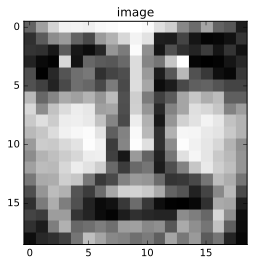

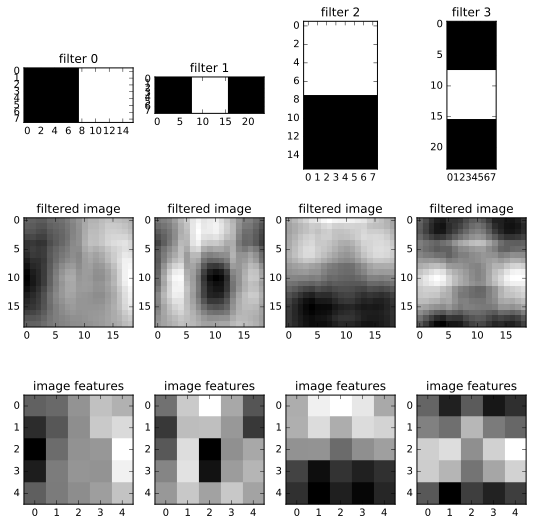

In [16]:
# new features
img = imgdata['train'][0]
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.title("image")
plt.figure(figsize=(9,9))
extract_features([img], doplot=True);

Now lets extract image features on the training and test sets.  It may take a few seconds.

In [17]:
trainXf = extract_features(imgdata['train'])
print trainXf.shape
testXf = extract_features(imgdata['test'])
print testXf.shape

(873, 100)
(944, 100)


### Detection using Image Features
Now train AdaBoost and SVM classifiers on the image feature data.  Evaluate on the test set.

In [18]:
### INSERT YOUR CODE HERE

In [19]:
scalerf = preprocessing.MinMaxScaler(feature_range=(-1,1))    # make scaling object
trainXfn = scalerf.fit_transform(trainXf)   # use training data to fit scaling parameters
testXfn  = scalerf.transform(testXf)        # apply scaling to test data

clfs2 = {}

In [20]:
# setup all the parameters and models
exps = {
    'svm-lin': {
        'paramgrid': {'C': logspace(-2,3,10)},
        'clf': svm.SVC(kernel='linear') },
    'svm-rbf': {
        'paramgrid': {'C': logspace(-2,3,10), 'gamma': logspace(-4,3,10) },
        'clf': svm.SVC(kernel='rbf') },
    'svm-poly': {
        'paramgrid': {'C': logspace(-2,3,10), 'degree': [2, 3, 4] },
        'clf': svm.SVC(kernel='poly') },   
    'ada': {
        'paramgrid': {'n_estimators': [2, 5, 10, 15, 20, 25, 30, 50, 100]},
        'clf': ensemble.AdaBoostClassifier(random_state=4487) },
    'rf': {
        'paramgrid': {'n_estimators': [2, 5, 10, 15, 20, 25, 30, 50, 100]},
        'clf': ensemble.RandomForestClassifier(random_state=4487) },
    }
clfs2 = {}

In [21]:
# run the experiment
for (name,ex) in exps.iteritems():
    print "=== " + name + " ==="
    if clfs2.has_key(name):
        print "exists skipping"
    else:
        myclf = grid_search.GridSearchCV(ex['clf'], ex['paramgrid'], cv=5, verbose=1)
        myclf.fit(trainXfn, trainY)

        print "best params:"
        print myclf.best_params_

        clfs2[name] = myclf

=== svm-lin ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.2s finished


best params:
{'C': 21.544346900318846}
=== rf ===
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    7.7s finished


best params:
{'n_estimators': 50}
=== ada ===
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   11.7s finished


best params:
{'n_estimators': 10}
=== svm-rbf ===
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   32.9s finished


best params:
{'C': 5.9948425031894086, 'gamma': 0.12915496650148839}
=== svm-poly ===
Fitting 5 folds for each of 30 candidates, totalling 150 fits
best params:
{'C': 1000.0, 'degree': 2}


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    7.1s finished


In [22]:
predYtrain = {}
predYtest  = {}
for (name,clf) in clfs2.iteritems():
    predYtrain[name] = clf.predict(trainXfn)
    predYtest[name]  = clf.predict(testXfn)
    
    # calculate accuracy
    trainacc = metrics.accuracy_score(trainY, predYtrain[name])
    testacc  = metrics.accuracy_score(testY, predYtest[name])

    print "%s: train=%0.3g; test=%0.3g" % (name, trainacc, testacc)

svm-lin: train=0.969; test=0.696
rf: train=1; test=0.807
svm-poly: train=0.987; test=0.814
svm-rbf: train=0.997; test=0.801
ada: train=0.904; test=0.791


In [24]:
testY = predYtest['svm-poly']
bestclf = clfs2['svm-poly']

### Error Analysis
Repeat the error analysis for the new classifiers.

In [25]:
### INSERT YOUR CODE HERE

Pind = where(testY==1) # indicies for face
Nind = where(testY==0) # indicies for non-face
TP = sum(testY[Pind] == predY[Pind])
FP = sum(testY[Pind] != predY[Pind])
TN = sum(testY[Nind] == predY[Nind])
FN = sum(testY[Nind] != predY[Nind])

TPR = float(TP) / (TP+FN)
FPR = float(FP) / (FP+TN)

print "TP="+str(TP)
print "FP="+str(FP)
print "TN="+str(TN)
print "FN="+str(FN)
print "TPR="+str(TPR)
print "FPR="+str(FPR)

TP=171
FP=163
TN=599
FN=11
TPR=0.93956043956
FPR=0.213910761155


How has the classifier using image features improved?
- INSERT YOUR ANSWER HERE
- lower FPR and lower  TPR.

# Test image
Now lets try your face detector on a real image.  Download the "nasa-small.png" image and put it in the same directory as your ipynb file.  The below code will load the image, crop out image patches and then extract features. (this may take a few minutes)

In [26]:
fname = "nasa-small.png"

(210, 480)


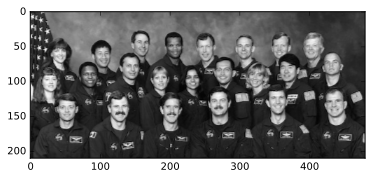

In [27]:
# load image
testimg3 = skimage.io.imread(fname)

# convert to grayscale
testimg = skimage.color.rgb2gray(testimg3)
print testimg.shape
plt.imshow(testimg, cmap='gray')

In [28]:
# step size for the sliding window
step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
psize = patches.shape
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3]))
print patches2.shape 

# histogram equalize patches (improves contrast)
patches3 = empty(patches2.shape)
for i in range(patches2.shape[0]):
    patches3[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])

# extract features
newXf = extract_features(patches3)

(5568, 19, 19)


Now predict using your classifier.  The extracted features are in `newXf`.

In [29]:
### YOUR CODE HERE
newXfn  = scalerf.transform(newXf)        # apply scaling to test data
prednewY = bestclf.predict(newXfn)

Now we we will view the results on the image.  Use the below code. `prednewY` is the vector of predictions.

(-0.5, 479.5, 209.5, -0.5)

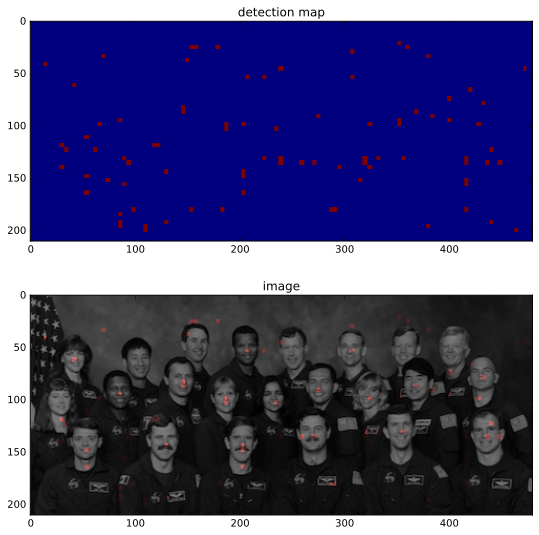

In [30]:
# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
# show detections with image
detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

_How did your face detector do?_
- INSERT YOUR ANSWER HERE
- got some faces, but also had lots of FP!

- You can try it on your own images.  The faces should all be around 19x19 pixels though.
- We only used 1/8 of the training data. Try using more data to train it!